In [1]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# Prepare the data

# Read the ILI activity data, and use only the relavant columns (Remember that the data is already sorted by year, week and then state)
ILI_dataframe = read_csv('final_project.csv', usecols = ['STATENAME', 'ACTIVITY LEVEL', 'WEEK', 'YEAR'])
print(ILI_dataframe)

           STATENAME ACTIVITY LEVEL  YEAR  WEEK
0            Alabama        Level 1  2008    40
1             Alaska        Level 1  2008    40
2            Arizona        Level 1  2008    40
3           Arkansas        Level 6  2008    40
4         California        Level 1  2008    40
...              ...            ...   ...   ...
31865       Virginia       Level 10  2020    12
31866     Washington       Level 10  2020    12
31867  West Virginia       Level 10  2020    12
31868      Wisconsin       Level 10  2020    12
31869        Wyoming        Level 7  2020    12

[31870 rows x 4 columns]


In [3]:
# Get the list of states 
list_of_states_complete = ILI_dataframe['STATENAME'].values # Get entire STATENAME column
states_unique = list(set(list_of_states_complete)) # Unique list of states, but not in alphabetical order
states_unique.sort() # Now in alphabetical order
print(states_unique)

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Commonwealth of the Northern Mariana Islands', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'New York City', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


In [4]:
# Get the list of activity levels
activity_levels_complete = ILI_dataframe['ACTIVITY LEVEL'].values # Get entire ACTIVITY LEVEL column
activity_levels = list(set(activity_levels_complete)) # Unique list of acitivity levels, not in order
activity_levels.sort() # Activity levels in order
activity_levels.append(activity_levels[2]) # Level 10 was incorrectly sorted, sort it manually
activity_levels.pop(2) # Now correctly sorted
print(activity_levels)

['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5', 'Level 6', 'Level 7', 'Level 8', 'Level 9', 'Level 10']


In [5]:
# Filter the rows with STATENAME as 'Alabama'
state_name = 'Alabama' # Can change this to loop over the list of states
ILI_Data_state = ILI_dataframe[ILI_dataframe['STATENAME'] == state_name]

# Then filter the rows that do not have year 2020 (We want to predict for the 2018-2019 season)
ILI_Data_state = ILI_Data_state[ILI_Data_state['YEAR'] != 2020]

# Finally, filter out the rows that are in the flu season (Rows with Week 40 to 52)
ILI_Data_state = ILI_Data_state[ILI_Data_state['WEEK'] >= 40]

ILI_Data_state_vals = ILI_Data_state.values

# Manually remove the duplicates in 2011 and 2016
ILI_Data_state_vals = np.delete(ILI_Data_state_vals, 52, 0)
ILI_Data_state_vals = np.delete(ILI_Data_state_vals, 117, 0)
print(ILI_Data_state_vals)

[['Alabama' 'Level 1' 2008 40]
 ['Alabama' 'Level 1' 2008 41]
 ['Alabama' 'Level 1' 2008 42]
 ['Alabama' 'Level 1' 2008 43]
 ['Alabama' 'Level 3' 2008 44]
 ['Alabama' 'Level 1' 2008 45]
 ['Alabama' 'Level 2' 2008 46]
 ['Alabama' 'Level 3' 2008 47]
 ['Alabama' 'Level 4' 2008 48]
 ['Alabama' 'Level 5' 2008 49]
 ['Alabama' 'Level 4' 2008 50]
 ['Alabama' 'Level 1' 2008 51]
 ['Alabama' 'Level 1' 2008 52]
 ['Alabama' 'Level 10' 2009 40]
 ['Alabama' 'Level 10' 2009 41]
 ['Alabama' 'Level 10' 2009 42]
 ['Alabama' 'Level 10' 2009 43]
 ['Alabama' 'Level 10' 2009 44]
 ['Alabama' 'Level 10' 2009 45]
 ['Alabama' 'Level 9' 2009 46]
 ['Alabama' 'Level 7' 2009 47]
 ['Alabama' 'Level 6' 2009 48]
 ['Alabama' 'Level 6' 2009 49]
 ['Alabama' 'Level 5' 2009 50]
 ['Alabama' 'Level 8' 2009 51]
 ['Alabama' 'Level 1' 2009 53]
 ['Alabama' 'Level 1' 2010 40]
 ['Alabama' 'Level 1' 2010 41]
 ['Alabama' 'Level 1' 2010 42]
 ['Alabama' 'Level 1' 2010 43]
 ['Alabama' 'Level 1' 2010 44]
 ['Alabama' 'Level 1' 2010 45]
 [

In [6]:
ILI_state_activities = list(ILI_Data_state_vals[:, 1])  # List of activity levels in the state
print(ILI_state_activities)

['Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 3', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5', 'Level 4', 'Level 1', 'Level 1', 'Level 10', 'Level 10', 'Level 10', 'Level 10', 'Level 10', 'Level 10', 'Level 9', 'Level 7', 'Level 6', 'Level 6', 'Level 5', 'Level 8', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 4', 'Level 4', 'Level 8', 'Level 10', 'Level 10', 'Level 7', 'Level 1', 'Level 1', 'Level 2', 'Level 3', 'Level 3', 'Level 5', 'Level 3', 'Level 4', 'Level 2', 'Level 6', 'Level 7', 'Level 8', 'Level 9', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 4', 'Level 10', 'Level 10', 'Level 10', 'Level 10', 'Level 10', 'Level 10', 'Level 1', 'Level 1', 'Level 1', 'Level 4', 'Level 3', 'Level 5', 'Level 5', 'Level 6', 'Level 7', 'Level 10', 'Level 10', 'Level 10', 'Level 10', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 5', 'Level 10', 'Level 10', 'Level 9', 'Level 10',

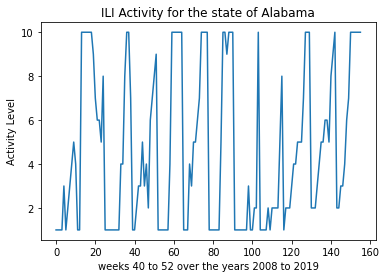

In [7]:
# Plot the state activity as function of weeks 40 to 52 over the years 2008 to 2019

def activity_to_int_plot(activity_lev):
  activity_int = activity_levels.index(activity_lev)
  return activity_int

y_plot = []
for activity_lev in ILI_state_activities:
  y_plot.append(activity_to_int_plot(activity_lev))

y_alter = np.empty_like(y_plot)
# print(y_alter)

plt.plot(y_plot)
# plt.plot(y_alter)
plt.xlabel('weeks 40 to 52 over the years 2008 to 2019')
plt.ylabel('Activity Level')
plt.title('ILI Activity for the state of ' + state_name)
plt.show()

In [0]:
# Now divide this into a train and test set
# We assume that we train on all of the data, except the last x weeks. The last x weeks will be used to test our predictions.
# x is defined below

num_lag_weeks = 1 # Number of weeks used as input to the LSTM
num_step_weeks = 1 # Number of weeks predicted as output by the LSTM

# x = num_lag_weeks + num_step_weeks
x = 50

train_state_activity = ILI_state_activities[:-x]
test_state_activity = ILI_state_activities[-x:]

In [9]:
# Function to one hot encode the ILI state activities (May be different for different states)

# Integer encoder for the state
label_encoder = LabelEncoder()
label_encoder.fit(ILI_state_activities)

integer_encoded_activities = label_encoder.transform(ILI_state_activities)
integer_encoded_activities = integer_encoded_activities.reshape(len(integer_encoded_activities), 1)
  
# Onehot encoder for the state
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(integer_encoded_activities)

def one_hot_encode_dataset(dataset):

  integer_encoded_dataset = label_encoder.transform(dataset)

  # Binary encode 
  integer_encoded_dataset = integer_encoded_dataset.reshape(len(integer_encoded_dataset), 1)
  onehot_encoded_dataset = onehot_encoder.transform(integer_encoded_dataset)

  return onehot_encoded_dataset

# One hot encode the train and test sets
train_state_activity_oh = one_hot_encode_dataset(train_state_activity)
test_state_activity_oh = one_hot_encode_dataset(test_state_activity)

print(train_state_activity_oh)
print(train_state_activity_oh.shape)


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(106, 10)


In [10]:
# Prepare the data for LSTM, using the sliding window approach. The input X must be of shape (num_samples, num_time_steps, num_features) and the output y must be the same as well.

def prepare_LSTM_data_from_oh(one_hot_dataset, n_lag, n_step):
  X_list = []
  y_list = []

  for i in range(len(one_hot_dataset) - (n_lag + n_step) + 1): 
    X_slice = one_hot_dataset[i:(i+n_lag), :]
    y_slice = one_hot_dataset[(i+n_lag): (i+n_lag+n_step), :]

    X_list.append(X_slice)
    y_list.append(y_slice)

  return np.array(X_list), np.array(y_list)

train_state_X, train_state_y = prepare_LSTM_data_from_oh(train_state_activity_oh, num_lag_weeks, num_step_weeks)
test_state_X, test_state_y = prepare_LSTM_data_from_oh(test_state_activity_oh, num_lag_weeks, num_step_weeks)

print(train_state_X)
print(train_state_X.shape)



[[[1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 1. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]]]
(105, 1, 10)


In [0]:
# Define the LSTM model architecture (For now, just work with 1 layer of LSTM with 4 units each, followed by softmax)
nb_of_units = 40

model_state_activity  = Sequential()
model_state_activity.add(LSTM(nb_of_units, input_shape=(train_state_X.shape[1], train_state_X.shape[2])))

model_state_activity.add(Dense(train_state_y.shape[1] * train_state_y.shape[2], activation = 'softmax')) # Need to figure out how to get a (13, 10) output
model_state_activity.add(Reshape((train_state_y.shape[1], train_state_y.shape[2])))


In [0]:
# Set hyperparameters for the training 
n_epochs = 100
n_batch = 1

# Compile the model, use the optimizer as 'Adam', and loss as 'categorical_crossentropy'
model_state_activity.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['acc'])

In [20]:
# Fit model to training set
results = model_state_activity.fit(train_state_X, train_state_y, epochs = n_epochs, batch_size = n_batch, shuffle = False, validation_data=(test_state_X, test_state_y)) # Make sure to keep the order of each batch

Train on 105 samples, validate on 49 samples
Epoch 1/100
105/105 [==============================] - 2s 14ms/step - loss: 2.2394 - acc: 0.3714 - val_loss: 2.2673 - val_acc: 0.1837
Epoch 2/100
105/105 [==============================] - 1s 10ms/step - loss: 2.0007 - acc: 0.4000 - val_loss: 2.2302 - val_acc: 0.0612
Epoch 3/100
105/105 [==============================] - 1s 13ms/step - loss: 1.7107 - acc: 0.3905 - val_loss: 2.2438 - val_acc: 0.0612
Epoch 4/100
105/105 [==============================] - 1s 9ms/step - loss: 1.5860 - acc: 0.4762 - val_loss: 2.1962 - val_acc: 0.2041
Epoch 5/100
105/105 [==============================] - 1s 9ms/step - loss: 1.5145 - acc: 0.5333 - val_loss: 2.1380 - val_acc: 0.2041
Epoch 6/100
105/105 [==============================] - 1s 9ms/step - loss: 1.4671 - acc: 0.5333 - val_loss: 2.0920 - val_acc: 0.2041
Epoch 7/100
105/105 [==============================] - 1s 9ms/step - loss: 1.4366 - acc: 0.5333 - val_loss: 2.0546 - val_acc: 0.2245
Epoch 8/100
105/105 [

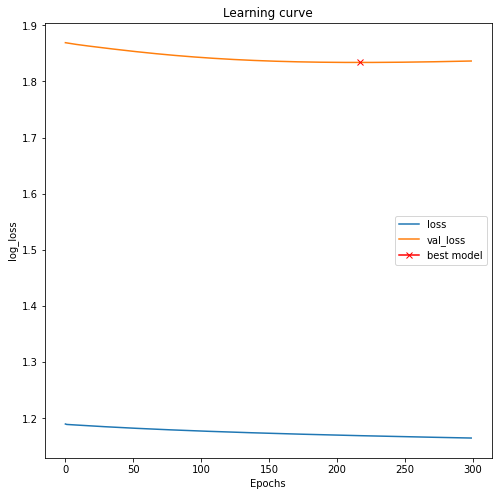

In [57]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

In [69]:
train_state_predicted_softmax = model_state_activity.predict(train_state_X)

# Only for 1 timestep
def softmax_pred_to_oh(softmax_pred):
  pred_oh = softmax_pred

  for i in range(len(softmax_pred)):
    i_row = softmax_pred[i, :, :]
    max_index = np.argmax(i_row)
    zero_arr = np.zeros((1, i_row.shape[1]))
    zero_arr[0, max_index] = 1
    pred_oh[i, :, :] = zero_arr

  return pred_oh

train_state_pred_oh = softmax_pred_to_oh(train_state_predicted_softmax)

print(train_state_pred_oh.shape)

(105, 1, 10)
